# Capstone Two - 5 Extended Modeling: PROPHET<a id='5'></a>

## 5.1 Contents<a id='5.1'></a>
* [5 Extended Modeling](#5)
  * [5.1 Contents](#5.1)
  * [5.2 Imports](#5.2)
  * [5.3 Load The Data](#5.3)
  * [5.4 Data Processing](#5.4)
  * [5.5 Modeling](#5.5)
    * [5.5.1 Apply Prophet() for single timeseries](#5.5.1)
    * [5.5.2 Apply Prophet() for multiple timeseries](#5.5.2)
    

## 5.2 Imports<a id='5.2'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
from prophet import Prophet

## 5.3 Load The Data<a id='5.3'></a>

In [3]:
data_dir = '../data/'

data_ori = pd.read_csv(data_dir+'train_all_groups.csv')
data_ori.head(3)

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,transferred,year,month
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1


In [4]:
data = data_ori[['date', 'store_nbr', 'family', 'sales']]
data.set_index('date', inplace = True)
data.head(3)

,store_nbr,family,sales
date,,,
2013-01-01,1,AUTOMOTIVE,0.0
2013-01-01,1,BABY CARE,0.0
2013-01-01,1,BEAUTY,0.0


## 5.4 Data Processing<a id='5.4'></a>

In [5]:
stores = data['store_nbr'].unique()
families = data['family'].unique()

print(stores)
print(families)
print(len(stores), len(families))

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
54 33


In [6]:
grp = data.groupby(['store_nbr', 'family'])

df = pd.DataFrame()

for s in stores:
    for f in families:
        grp_sel = grp.get_group((s, f))
        col_name = str(s)+","+f
        df_temp = pd.DataFrame(grp_sel['sales']).rename(columns={'sales': col_name})
        df = pd.concat([df, df_temp], axis=1)

df.head()

,"1,AUTOMOTIVE","1,BABY CARE","1,BEAUTY","1,BEVERAGES","1,BOOKS","1,BREAD/BAKERY","1,CELEBRATION","1,CLEANING","1,DAIRY","1,DELI",...,"9,MAGAZINES","9,MEATS","9,PERSONAL CARE","9,PET SUPPLIES","9,PLAYERS AND ELECTRONICS","9,POULTRY","9,PREPARED FOODS","9,PRODUCE","9,SCHOOL AND OFFICE SUPPLIES","9,SEAFOOD"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000
2013-01-02,2.0,0.0,2.0,1091.0,0.0,470.652,0.0,1060.0,579.0,164.069,...,0.0,374.531,482.0,0.0,0.0,651.292,83.0,0.0,0.0,29.214
2013-01-03,3.0,0.0,0.0,919.0,0.0,310.655,0.0,836.0,453.0,151.582,...,0.0,400.863,372.0,0.0,0.0,509.496,66.0,0.0,0.0,25.000
2013-01-04,3.0,0.0,3.0,953.0,0.0,198.366,0.0,827.0,460.0,131.411,...,0.0,310.878,324.0,0.0,0.0,332.672,57.0,0.0,0.0,11.000
2013-01-05,5.0,0.0,3.0,1160.0,0.0,301.057,0.0,811.0,464.0,118.613,...,0.0,447.685,461.0,0.0,0.0,510.919,84.0,0.0,0.0,28.361


Totally 54*33 = 1782 time series.

In [7]:
# convert datetime index to period
df.index = pd.DatetimeIndex(df.index).to_period('D')

In [8]:
# Fill time gaps on Christmas every year
df = df.resample('1D').mean().ffill()#interpolate() # forward fill or interpolate didn't affect the mAPE result

In [9]:
# Sales are zeros on New Year's Day (Store Closed)
df.loc[['2014-01-01']] = df.loc[['2013-12-31']].values
df.loc[['2015-01-01']] = df.loc[['2014-12-31']].values
df.loc[['2016-01-01']] = df.loc[['2015-12-31']].values
df.loc[['2017-01-01']] = df.loc[['2016-12-31']].values

In [10]:
df = df.to_timestamp(freq='D') # type from period to datetime

In [11]:
# train-test split: the last 16 days as testing set
n_train = len(df)-16
df_train = df[7:n_train] #starting from day 8
df_test = df[n_train:]

## 5.5 Modeling<a id='5.5'></a>

### 5.5.1 Apply Prophet() for single timeseries<a id='5.5.1'></a>

Try Prophet() using the time series in the first column.

In [12]:
y1_train = df_train["1,AUTOMOTIVE"] # first column
y1_test = df_test["1,AUTOMOTIVE"]

y1_train = y1_train.reset_index() # Prophet() needs the date as a column
y1_test = y1_test.reset_index()

y1_train.columns = ['ds','y']
y1_test.columns = ['ds','y']

In [13]:
model = Prophet()
model.fit(y1_train)

03:12:43 - cmdstanpy - INFO - Chain [1] start processing
03:12:43 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
y1_pred = model.predict(y1_test)  # predict N steps into the future
y1_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2017-07-31,4.705152,1.673049,8.155748
1,2017-08-01,5.275146,1.947262,8.315614
2,2017-08-02,4.893452,1.954730,8.170093
3,2017-08-03,4.389126,1.288824,7.752301
4,2017-08-04,5.115617,1.781876,8.206517


In [15]:
# APE = ABS((actual - predicted) / actual)
APE_y1 = abs( (y1_test['y'] - y1_pred['yhat']) / y1_test['y'])

# MEAN(APE)
mAPE_y1 = np.mean(APE_y1)
print('MAPE: '+str(mAPE_y1))

MAPE: 0.75584475388413


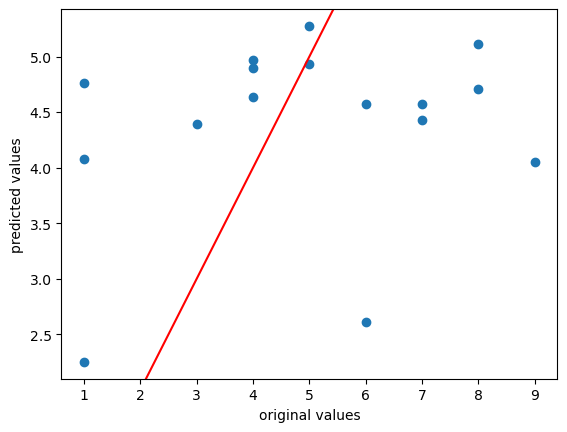

In [16]:
# predicted-vs-actual scatterplot
fig, ax = plt.subplots()
ax.scatter(y1_test['y'], y1_pred['yhat'])
plt.xlabel("original values")
plt.ylabel("predicted values")
ax.axline((3,3), slope=1, color = 'red')
plt.show()

We can see the mean APE is quite large, and the scatter plot also shows poor prediction results. The Prophet model may not be a good model for this specific time series, and we'll try to use Prophet() for some other time series. 

### 5.5.2 Apply Prophet() for multiple timeseries<a id='5.5.2'></a>

In [17]:
stores1 = [*range(1, 7, 1)] # No.1-6 stores
families1 = ['BREAD/BAKERY', 'DAIRY', 'GROCERY I']

grp = data.groupby(['store_nbr', 'family'])

df0 = pd.DataFrame()

for s in stores1:
    for f in families1:
        grp_sel = grp.get_group((s, f))
        col_name = str(s)+","+f
        df_temp = pd.DataFrame(grp_sel['sales']).rename(columns={'sales': col_name})
        df0 = pd.concat([df0, df_temp], axis=1)

df0.head()

,"1,BREAD/BAKERY","1,DAIRY","1,GROCERY I","2,BREAD/BAKERY","2,DAIRY","2,GROCERY I","3,BREAD/BAKERY","3,DAIRY","3,GROCERY I","4,BREAD/BAKERY","4,DAIRY","4,GROCERY I","5,BREAD/BAKERY","5,DAIRY","5,GROCERY I","6,BREAD/BAKERY","6,DAIRY","6,GROCERY I"
date,,,,,,,,,,,,,,,,,,
2013-01-01,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0
2013-01-02,470.652,579.0,2652.0,523.882,651.0,3870.0,1361.636,1606.0,8463.0,422.537,589.0,4087.0,566.917,414.0,4558.0,689.217,683.0,5535.0
2013-01-03,310.655,453.0,2121.0,321.693,461.0,2640.0,886.184,1377.0,6712.0,273.752,431.0,2824.0,377.887,366.0,3260.0,412.324,542.0,4040.0
2013-01-04,198.366,460.0,2056.0,299.012,480.0,2697.0,784.331,1244.0,5731.0,278.560,411.0,2688.0,335.761,309.0,3085.0,306.411,481.0,3314.0
2013-01-05,301.057,464.0,2216.0,385.333,620.0,3545.0,1066.981,1458.0,7823.0,371.690,660.0,3731.0,402.286,356.0,3398.0,502.045,654.0,4857.0


In [18]:
df0.index = pd.DatetimeIndex(df0.index).to_period('D')
df0 = df0.resample('1D').mean().ffill()#interpolate()

In [19]:
df0.loc[['2014-01-01']] = df0.loc[['2013-12-31']].values
df0.loc[['2015-01-01']] = df0.loc[['2014-12-31']].values
df0.loc[['2016-01-01']] = df0.loc[['2015-12-31']].values
df0.loc[['2017-01-01']] = df0.loc[['2016-12-31']].values

In [20]:
df0 = df0.to_timestamp(freq='D') # type from period to datetime

In [21]:
# Train-Test Split
df1_train = df0[7:n_train] #starting from day 8
df1_test = df0[n_train:]

In [22]:
# N = len(df1.columns)
mAPE = []
for group in df0.columns:
    y_train = df1_train[group]
    y_test = df1_test[group]
    
    y_train = y_train.reset_index() # Prophet() needs the "date" as a column
    y_test = y_test.reset_index()
    
    y_train.columns = ['ds','y']
    y_test.columns = ['ds','y']
    
    model = Prophet().fit(y_train)
    
    y_pred = model.predict(y_test)
    
    APE_y = abs( (y_test['y'] - y_pred['yhat']) / y_test['y'])
    mAPE_y = np.mean(APE_y)
    print(group+' MAPE: '+str(mAPE_y))
    
    mAPE.append(mAPE_y)


03:12:44 - cmdstanpy - INFO - Chain [1] start processing
03:12:44 - cmdstanpy - INFO - Chain [1] done processing
03:12:44 - cmdstanpy - INFO - Chain [1] start processing


1,BREAD/BAKERY MAPE: 0.21747281803135288


03:12:44 - cmdstanpy - INFO - Chain [1] done processing
03:12:44 - cmdstanpy - INFO - Chain [1] start processing


1,DAIRY MAPE: 0.17968026631127557


03:12:44 - cmdstanpy - INFO - Chain [1] done processing
03:12:45 - cmdstanpy - INFO - Chain [1] start processing


1,GROCERY I MAPE: 0.2182684978824601


03:12:45 - cmdstanpy - INFO - Chain [1] done processing
03:12:45 - cmdstanpy - INFO - Chain [1] start processing


2,BREAD/BAKERY MAPE: 0.1109577496634915


03:12:45 - cmdstanpy - INFO - Chain [1] done processing
03:12:45 - cmdstanpy - INFO - Chain [1] start processing
03:12:45 - cmdstanpy - INFO - Chain [1] done processing


2,DAIRY MAPE: 0.11200764266639877


03:12:46 - cmdstanpy - INFO - Chain [1] start processing
03:12:46 - cmdstanpy - INFO - Chain [1] done processing


2,GROCERY I MAPE: 0.12214112131314822


03:12:46 - cmdstanpy - INFO - Chain [1] start processing


3,BREAD/BAKERY MAPE: 0.09012809820223644


03:12:46 - cmdstanpy - INFO - Chain [1] done processing
03:12:46 - cmdstanpy - INFO - Chain [1] start processing
03:12:46 - cmdstanpy - INFO - Chain [1] done processing


3,DAIRY MAPE: 0.0796038291576715


03:12:46 - cmdstanpy - INFO - Chain [1] start processing


3,GROCERY I MAPE: 0.1335519041177018


03:12:46 - cmdstanpy - INFO - Chain [1] done processing
03:12:47 - cmdstanpy - INFO - Chain [1] start processing


4,BREAD/BAKERY MAPE: 0.20967049918295066


03:12:47 - cmdstanpy - INFO - Chain [1] done processing
03:12:47 - cmdstanpy - INFO - Chain [1] start processing


4,DAIRY MAPE: 0.1178158110205845


03:12:47 - cmdstanpy - INFO - Chain [1] done processing
03:12:47 - cmdstanpy - INFO - Chain [1] start processing


4,GROCERY I MAPE: 0.1871411834210932


03:12:47 - cmdstanpy - INFO - Chain [1] done processing
03:12:48 - cmdstanpy - INFO - Chain [1] start processing


5,BREAD/BAKERY MAPE: 0.1027212199369201


03:12:48 - cmdstanpy - INFO - Chain [1] done processing
03:12:48 - cmdstanpy - INFO - Chain [1] start processing


5,DAIRY MAPE: 0.07847948012602116


03:12:48 - cmdstanpy - INFO - Chain [1] done processing
03:12:48 - cmdstanpy - INFO - Chain [1] start processing


5,GROCERY I MAPE: 0.09944426732804042


03:12:48 - cmdstanpy - INFO - Chain [1] done processing
03:12:48 - cmdstanpy - INFO - Chain [1] start processing


6,BREAD/BAKERY MAPE: 0.13366613475715258


03:12:49 - cmdstanpy - INFO - Chain [1] done processing
03:12:49 - cmdstanpy - INFO - Chain [1] start processing
03:12:49 - cmdstanpy - INFO - Chain [1] done processing


6,DAIRY MAPE: 0.106613041500985
6,GROCERY I MAPE: 0.11783052621314455


In [23]:
df_mape = pd.DataFrame()
df_mape['Group'] = df0.columns#[0:18]
df_mape['MAPE'] = mAPE
df_mape.sort_values(by=['MAPE'])

,Group,MAPE
13,"5,DAIRY",0.078479
7,"3,DAIRY",0.079604
6,"3,BREAD/BAKERY",0.090128
14,"5,GROCERY I",0.099444
12,"5,BREAD/BAKERY",0.102721
16,"6,DAIRY",0.106613
3,"2,BREAD/BAKERY",0.110958
4,"2,DAIRY",0.112008
10,"4,DAIRY",0.117816
17,"6,GROCERY I",0.117831


In [24]:
print("\033[1m"+"Top 3 MAPE:")
df_mape.nsmallest(3, 'MAPE')

Top 3 MAPE:


,Group,MAPE
13,"5,DAIRY",0.078479
7,"3,DAIRY",0.079604
6,"3,BREAD/BAKERY",0.090128


In [25]:
print("\033[1m"+"Bottom 3 MAPE:")
df_mape.nlargest(3, 'MAPE')

Bottom 3 MAPE:


,Group,MAPE
2,"1,GROCERY I",0.218268
0,"1,BREAD/BAKERY",0.217473
9,"4,BREAD/BAKERY",0.209670
